## Using WhyLogs to Profile Images
---

This notebook provides an example how you can use whylogs to profile unstructure data like images.

In [14]:
from PIL import Image
import numpy as np
import os
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


withd :	300
height:	225
number of pixels:67500


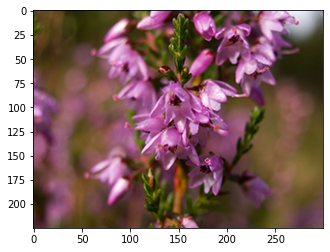

In [15]:
with open("../testdata/images/flower2.jpg","rb") as img_f:
    img= Image.open(img_f)
    imshow(np.asarray(img))
    w,h = img.size
    total_num_pixels= w*h
    print("withd :\t{}\nheight:\t{}\nnumber of pixels:{}".format(w,h,total_num_pixels))

We can create logger and create a profile sketch of the image data

In [16]:
from whylogs import get_or_create_session
_session=None
session = get_or_create_session()
logger=session.logger("image_dataset2")
file_names = []
for i in range(1, 11):
    file_names.append(os.path.join("..","testdata", "images","flower" + str(i) +".jpg"))

for i in range(1, 8):
    logger.log_image(file_names[i])
profile=logger.profile



You can obtain the histogram sketch of image data features. e.g Saturation below

In [17]:
imageProfiles = profile.flat_summary()["hist"]
print(imageProfiles["Saturation.mean"])

{'bin_edges': [55.896366119384766, 98.8644075115345, 141.83244890368422, 184.80049029583398, 227.7685316879837], 'counts': [4, 2, 4, 4]}


Along with all the metadata collected from the image

In [18]:
print(profile.flat_summary()["summary"]["column"].values)

['ImageLength' 'BrightnessValue' 'Y-Resolution'
 'PhotometricInterpretationSamplesPerPixel' 'Flash' 'Hue.mean'
 'Saturation.mean' 'Model' 'ResolutionUnit' 'ImageWidth' 'BitsPerSample'
 'Brightness.stddev' 'Saturation.stddev' 'Brightness.mean' 'Software'
 'Compression' 'ExposureTime' 'X-Resolution' 'RowsPerStrip' 'Quality'
 'Hue.stddev' 'Orientation']


In [19]:
len(imageProfiles["Saturation.mean"]['bin_edges'])

5

## Custom Functions
---


One can also create custom functions to profile image specific features. E.g. Two example below demostrate get the average of image pixels per column, while the second function simple allow you to create a distribution sketch of the blue values. Also ComposeTransforms functions allow you mix and match functions to create new features to monitor.

In [20]:
class AvgValue:
    
    def __call__(self, x):
        return np.mean(np.array(x)).reshape(-1,1)
    def __repr__(self,):
        return self.__class__.__name__

In [21]:
class MyBlue:
    def __call__(self, x):
        _,_,b= x.split()
        return np.array(b).reshape(-1,1)
    def __repr__(self,):
        return self.__class__.__name__

In [22]:
from whylogs.features.transforms import ComposeTransforms
_session=None
session=None
session = get_or_create_session()
logger2=session.logger("image_dataset_custom_functions")

for i in range(3, 10):
    logger2.log_image(file_names[i], feature_transforms = [ AvgValue(), MyBlue(), ComposeTransforms([MyBlue(),AvgValue()])])


profile2=logger2.profile

print(profile2.flat_summary()["summary"]["column"].values)

['Y-Resolution' 'Hue.mean' 'Saturation.stddev' 'Flash' 'Software'
 'ResolutionUnit' 'RowsPerStrip' 'Compression' 'Hue.stddev' 'ExposureTime'
 'ImageLength' 'Saturation.mean' 'BitsPerSample' 'Model' 'Quality'
 'AvgValue(MyBlue(IMG))' 'Orientation' 'ImageWidth' 'Brightness.stddev'
 'BrightnessValue' 'MyBlue' 'Brightness.mean' 'AvgValue' 'X-Resolution'
 'PhotometricInterpretationSamplesPerPixel']


## Check histograms 

We can obtain the idenvidual histograms for the features  

In [23]:
minnpf = np.frompyfunc(lambda x, y: min(x,y), 2, 1)
maxnpf = np.frompyfunc(lambda x, y: max(x,y), 2, 1)


def get_custom_histogram_info(profiles, variable, n_bins):
    summaries = [profile.flat_summary()["summary"] for profile in profiles]
    min_range= minnpf.accumulate([ summary[summary["column"]==variable]["min"].values[0] for summary in summaries], dtype=object).astype(int)
    max_range= maxnpf.accumulate([ summary[summary["column"]==variable]["max"].values[0] for summary in summaries], dtype=object).astype(int)
    
    bins = np.linspace(int(min_range), int(max_range), int((max_range-min_range)/n_bins))

    counts= [ profile.columns[variable].number_tracker.histogram.get_pmf(bins[:-1]) for profile in profiles]
    return bins, counts


def plot_distribution_shift(profiles, variable, n_bins):
    """Visualization for distribution shift"""
    
    bins, counts = get_custom_histogram_info(profiles, variable, n_bins)

    fig, ax = plt.subplots(figsize=(10, 3))
    for idx, profile in enumerate(profiles):
        sns.histplot(x=bins, weights=counts[idx], bins=n_bins, 
                 label=profile.name, alpha=0.7, ax=ax)
   
    ax.legend()
    plt.show()


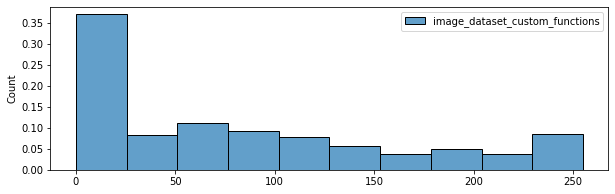

In [24]:
plot_distribution_shift([profile2],"MyBlue",10)

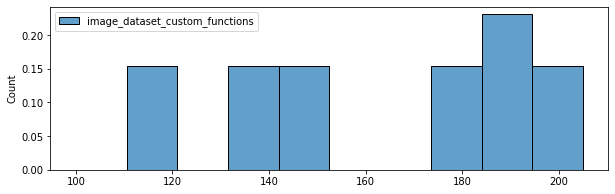

In [37]:
plot_distribution_shift([profile2],"Brightness.mean",10)

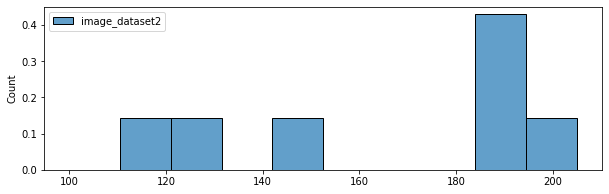

In [38]:
plot_distribution_shift([profile],"Brightness.mean",10)